### Importing Libraries

---

In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Seaborn Style

---

In [2]:
sns.set_theme('paper')
sns.set_style('ticks')

### Adding `utils` to `PYTHONPATH`

---

In [3]:
sys.path.append(os.path.abspath("../utils"))

### Reading Parquet File

---

In [4]:
# Importing load_parquet function from read_data module
from read_data import load_parquet
cars = load_parquet('clean_data', 'clean_data_after_eda.parquet')
cars.head()

,km_driven,fuel_type,transmission,owner,price,engine_capacity,year,brand,model
0,88760,Petrol,Manual,1st owner,219000,998,2012,Maruti,Wagon R 1.0
1,17920,Petrol,Manual,1st owner,266000,796,2016,Maruti,Alto 800
2,9940,Petrol,Manual,1st owner,496000,1373,2014,Maruti,Ertiga
3,67340,Petrol,Manual,2nd owner,355000,1199,2016,Tata,Tiago
4,30390,Petrol,Manual,1st owner,530000,998,2023,Maruti,New Wagon-R


In [5]:
# Since we have removed some data while exploratory data analysis,
# Some of the categories in categorical columns might got removed but the category will still be present
# Because we have converted object datatype into category datatype, so we have to remove these unused categories manually
cat_col = cars.select_dtypes(include='category').columns
for column in cat_col:
    cars[column] = cars[column].cat.remove_unused_categories()

### Handling High Cardinality Column  

---

In [6]:
# Frequency Distribution of "model" column
# As we can see, "model" column contains huge number of categories, which can cause problem when we apply OneHotEncoding on it
# It will create too many columns and cause sparsity (having too many zeros)
print(f'Unique categories in "model" column : {len(cars['model'].unique())}')

Unique categories in "model" column : 124


In [7]:
# So we are using model frequencies in place of original "model" column
model_freq = cars['model'].value_counts(normalize=True)

In [8]:
# Mapping model frequencies to "model" column
cars['model_freq'] = cars['model'].map(model_freq)

In [9]:
# Removing original "model" column
cars.drop('model', axis=1, inplace=True)

### Importing Libraries for Pipeline

---

In [10]:
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, KFold, learning_curve, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor

### Creating Training and Testing Set

---

In [11]:
# Creating Features and Target Variable
X = cars.drop('price', axis=1)
y = cars['price']

In [12]:
# Splitting Data into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
# Size of Training and Testing Set
print(f"Training Data : {X_train.shape[0]} | Testing Data : {X_test.shape[0]}")

Training Data : 1917 | Testing Data : 639


### Building Pipeline

---

#### Component for Nominal Column

In [14]:
nominal_cols = ['fuel_type','transmission','brand']

In [15]:
nominal_trf = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

#### Component for Ordinal Column

In [16]:
ordinal_cols = ['owner']

In [17]:
ordinal_categories = [['Others','3rd owner','2nd owner','1st owner']]

In [18]:
ordinal_trf = Pipeline(steps=[
    ('oe', OrdinalEncoder(categories=ordinal_categories))
])

#### Component for Numerical Column

In [19]:
numerical_cols = ['km_driven','year','engine_capacity']

In [20]:
numerical_trf = Pipeline(steps=[
    ('scaler', RobustScaler())
])

#### Adding Everything into ColumnTransformer

In [21]:
ctf = ColumnTransformer(transformers=[
    ('nominal', nominal_trf, nominal_cols),
    ('ordinal', ordinal_trf, ordinal_cols),
    ('scaling', numerical_trf, numerical_cols)
], remainder='passthrough', n_jobs=-1)

### Evaluating Multiple Models

---

In [22]:
# Importing Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [23]:
# Models Dictionary
models = {
    'LR' : LinearRegression(n_jobs=-1),
    'KNN' : KNeighborsRegressor(n_jobs=-1),
    'DT' : DecisionTreeRegressor(random_state=42),
    'RF' : RandomForestRegressor(random_state=42, n_jobs=-1),
    'GB' : GradientBoostingRegressor(random_state=42),
    'XGB' : XGBRegressor(random_state=42, n_jobs=-1)
}

In [24]:
# Computing Average Error and R2-Score through Cross-Validation
results = {}

for name, model in models.items():
    
    pipe = Pipeline(steps=[
        ('preprocessor', ctf),
        ('model', model)
    ])

    k = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1, return_train_score=False)

    results[name] = {'avg_error': -cv_results['test_mae'].mean(),'avg_score': cv_results['test_r2'].mean()}

    print()
    print(f'Model : {name}')
    print('-'*40)
    print(f'Average Error : {-cv_results['test_mae'].mean():.2f}')
    print(f'Standard Deviation of Error : {cv_results['test_mae'].std():.2f}')
    print(f'Average R2-Score : {cv_results['test_r2'].mean():.2f}')
    print(f'Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}')


Model : LR
----------------------------------------
Average Error : 123190.02
Standard Deviation of Error : 6445.18
Average R2-Score : 0.77
Standard Deviation of R2-Score : 0.01

Model : KNN
----------------------------------------
Average Error : 115572.16
Standard Deviation of Error : 3883.19
Average R2-Score : 0.79
Standard Deviation of R2-Score : 0.00

Model : DT
----------------------------------------
Average Error : 118466.64
Standard Deviation of Error : 4490.62
Average R2-Score : 0.76
Standard Deviation of R2-Score : 0.03

Model : RF
----------------------------------------
Average Error : 90811.20
Standard Deviation of Error : 2335.09
Average R2-Score : 0.86
Standard Deviation of R2-Score : 0.01

Model : GB
----------------------------------------
Average Error : 98056.52
Standard Deviation of Error : 3001.29
Average R2-Score : 0.85
Standard Deviation of R2-Score : 0.01

Model : XGB
----------------------------------------
Average Error : 91595.94
Standard Deviation of Error

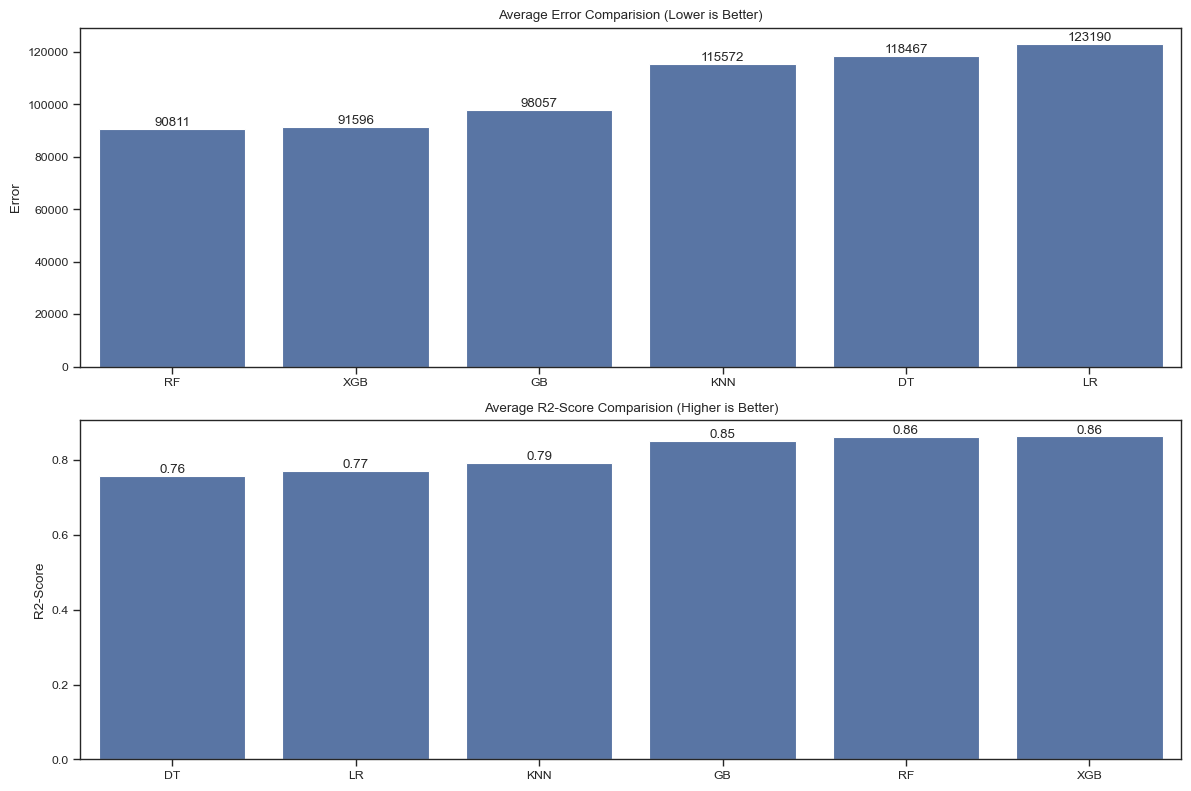

In [25]:
# Plotting Metric Comparision Graph
results_df = pd.DataFrame(results)

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(12,8))

sns.barplot(x=results_df.iloc[0,:].sort_values().index.to_list(), y=results_df.iloc[0,:].sort_values().values, ax=ax[0])
ax[0].set_title('Average Error Comparision (Lower is Better)')
ax[0].set_ylabel('Error')
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f')

sns.barplot(x=results_df.iloc[1,:].sort_values().index.to_list(), y=results_df.iloc[1,:].sort_values().values, ax=ax[1])
ax[1].set_title('Average R2-Score Comparision (Higher is Better)')
ax[1].set_ylabel('R2-Score')
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()

### Creating Stacking Regressor

---

- The above graph shows model performance based on average error (lower is better) and average R2-Score (higher is better).
- RandomForestRegressor, XGBRegressor and GradientBoostingRegressor are the top-performing models :
    - RF has the lowest error and highest R2-Score.
    - XGB and GB also closely follows with strong performance on both metrics.
- To leverage their strengths, I used (RF + XGB + GB) as base models in a StackingRegressor because :
    - RF handles non-linearities and interactions effectively.
    - XGB and GB excel in reducing bias and variance, boosting predictive power.
    - Combining these models captures a wider range of patterns in the data.
- ElasticNet is used as the final estimator because :
    - It combines L1 and L2 regularization, improving generalization and reducing overfitting.
- This stacked approach results in a more robust and accurate predictive model.

In [26]:
# Creating Object of the Models
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gb = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, n_jobs=-1)
meta_model = ElasticNet(max_iter=10000, random_state=42)

In [27]:
# Assigning Base Model for StackingRegressor
base_model = [('rf', rf),('xgb', xgb),('gb', gb)]

In [28]:
# Structure of StackingRegressor
stack = StackingRegressor(
    estimators=base_model, 
    final_estimator=meta_model, 
    passthrough=False, 
    cv=k, n_jobs=-1
)

In [29]:
# Final Pipeline with StackingRegressor
pipe = Pipeline(steps=[
    ('preprocessor', ctf), 
    ('model', stack) 
])

In [30]:
# Average Error and R2-Score through Cross-Validation
cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=k, scoring={'mae':'neg_mean_absolute_error','r2':'r2'}, n_jobs=-1)
print(f"Average Error : {-cv_results['test_mae'].mean():.2f}")
print(f"Standard Deviatacion of Error : {cv_results['test_mae'].std():.2f}")
print(f"Average R2-Score : {cv_results['test_r2'].mean():.2f}")
print(f"Standard Deviation of R2-Score : {cv_results['test_r2'].std():.2f}")

Average Error : 87885.34
Standard Deviatacion of Error : 1279.54
Average R2-Score : 0.87
Standard Deviation of R2-Score : 0.01


- StackingRegressor is clearly outperforming all the individual models we tested earlier.
- The stacked ensemble model (RF + XGB + GB + ElasticNet) improved performance over base models, achieving the lowest average error of ₹87,885.
- It's also quite consistent, with the lowest average standard deviation of error (₹1,279), clearly beating all standalone models.
- It's also very strong and stable in explaining variance in the data with an average R2-Score of 0.87, on par with top models like RF and XGB.

### Performance Evaluation Graphs

---

In [31]:
# Fitting the Pipeline
pipe.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('nominal', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-1
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [32]:
# Prediction from Pipeline (Using Cross-Validation)
y_pred = cross_val_predict(estimator=pipe, X=X_train, y=y_train, cv=k, n_jobs=-1)

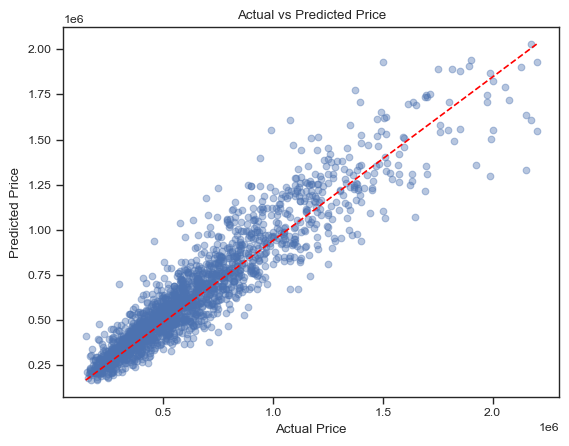

In [33]:
# Actual vs Predicted Plot
plt.scatter(y_train, y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

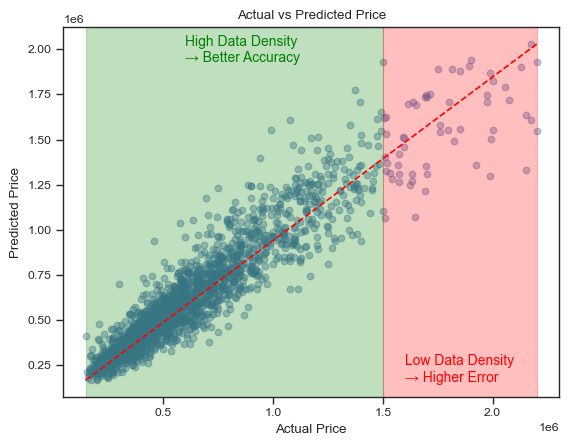

In [34]:
# Region with consistent and accurate predictions (Green : price < 15 lakhs)
# Region with more variation in predictions (Red : price > 15 lakhs)
plt.scatter(y_train, y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_pred.min(), y_pred.max()], color='red', linestyle='--')
plt.axvspan(xmin=y_train.min(), xmax=1500000, alpha=0.25, color='green')
plt.axvspan(xmin=1500000, xmax=y_train.max(), alpha=0.25, color='red')
plt.text(600000, max(y_pred)*0.95, 'High Data Density\n→ Better Accuracy', 
         fontsize=10, color='green')
plt.text(1600000, min(y_pred)*0.95, 'Low Data Density\n→ Higher Error', 
         fontsize=10, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

In [35]:
print(f'Cars with price less than or equal to 15 lakhs : {len(cars[cars['price'] <= 1500000])}')
print(f'Cars with price greater than 15 lakhs : {len(cars[cars['price'] > 1500000])}')

Cars with price less than or equal to 15 lakhs : 2480
Cars with price greater than 15 lakhs : 76


- Most predictions are close to the red line, which represents reasonably good prediction (y_true ≈ y_pred).
- This indicates that our model is capturing price behavior quite effectively.
- Especially in the lower to mid-price range, where the density of data points is highest, the model is learning and generalizing well.
- Deviation increases at higher price range (roughly above 15 Lakhs), which is obvious because of the nature of our data.
- We have very few data for expensive cars (cars above 15 lakhs) and huge data for cheap midrange cars (cars below 15 lakhs).
- The model is not exposed to enough data to learn the characteristics of expensive cars as compared to cheap mid-range cars.

In [36]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe, X=X_train, y=y_train, cv=k, shuffle=True, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

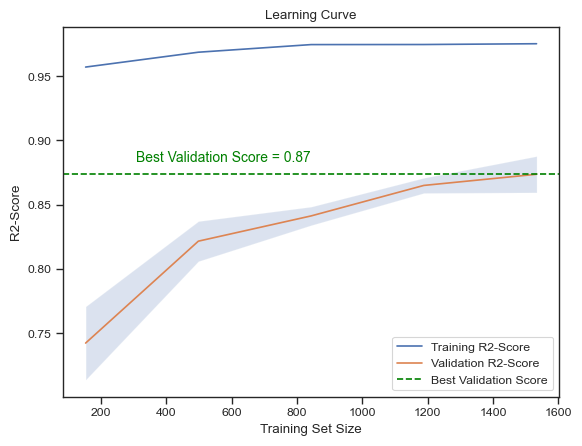

In [37]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training R2-Score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation R2-Score')
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('R2-Score')
plt.title('Learning Curve')
plt.axhline(y=val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Score')
plt.text(train_sizes[-3], (val_scores.mean(axis=1)[-1]+0.01), f'Best Validation Score = {val_scores.mean(axis=1)[-1]:.2f}', color='green', fontsize=10, ha='right')
plt.legend(loc='lower right')
plt.show()

- The model performs very well on the training data (R2-Score close to 1), but starts off weaker on validation data.
- As the training size increases, the validation score improves steadily.
- The best validation score is 0.87, reached at the largest training size (~1500 samples).
- The gap between training and validation scores gets smaller with more data, meaning the model is generalizing better.
- The shaded area shows variation in validation scores, which gets smaller with more training data, making the model's performance more stable.
- Although the performance improves, the variability in the shaded area indicates the model is still not perfectly stable in its generalization.

In [38]:
# Plotting Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipe, X=X_train, y=y_train, cv=k, shuffle=True, scoring='neg_mean_absolute_error',
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42, n_jobs=-1
)

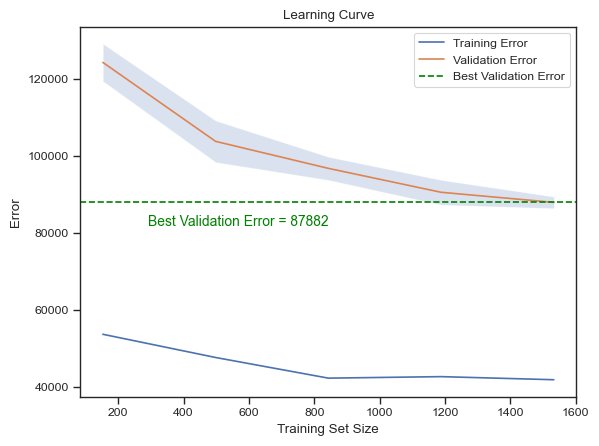

In [39]:
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training Error')
plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validation Error')
plt.fill_between(train_sizes,
                 -val_scores.mean(axis=1) - (-val_scores.std(axis=1)),
                 -val_scores.mean(axis=1) + (-val_scores.std(axis=1)),
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curve')
plt.axhline(y=-val_scores.mean(axis=1)[-1], color='green', linestyle='--', label='Best Validation Error')
plt.text(train_sizes[-3], (-val_scores.mean(axis=1)[-1]-6000), f'Best Validation Error = {-val_scores.mean(axis=1)[-1]:.0f}', color='green', fontsize=10, ha='right')
plt.legend(loc='upper right')
plt.show()

- Training error is low and flattens early, indicating the model fits training data very well.
- Validation error is much higher than training error, especially with smaller training sets, a sign of overfitting.
- Both training and validation errors decrease as the training size increases, which is a good sign.
- It means more data helps the model generalize better.
- The gap between training and validation errors remains significant, but it narrows with more data, reducing overfitting.
- Best validation error is ₹87,882, achieved at the largest training size (~1500 samples).
- The shaded region around validation error represents variability, which decreases with more data, indicating more consistent model performance.

### Hyperparameter Tuning

---

- The training error is low, meaning the model fits the training data well.
- But the validation error is much higher, showing a clear gap, which signals overfitting.
- Narrowing the gap between training and validation errors will lead to better generalization on unseen data.
- A less overfit model will capture the true patterns in the data instead of memorizing the noise.
- It also increases model robustness, making predictions more reliable on new data.

In [40]:
# Parameter Distribution
param_dist = {
    'model__rf__n_estimators': [200, 300],
    'model__rf__max_depth': [10, 20],
    'model__rf__min_samples_leaf': [3, 5],
    'model__rf__min_samples_split': [5, 7],
    'model__xgb__n_estimators': [200, 300],
    'model__xgb__learning_rate': [0.05, 0.1],
    'model__xgb__max_depth': [2, 4],
    'model__xgb__subsample': [0.5, 0.75],
    'model__xgb__colsample_bytree': [0.5, 0.75],
    'model__gb__n_estimators': [100, 200],   
    'model__gb__learning_rate': [0.05, 0.1],  
    'model__gb__max_depth': [2, 4],       
    'model__gb__subsample': [0.5, 0.75],
    'model__final_estimator__alpha': [0.1, 10.0],
    'model__final_estimator__l1_ratio': [0.0, 1.0]
}

In [41]:
# RandomizedSearch Object with Cross-Validation
rcv = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, cv=k, scoring='neg_mean_absolute_error', n_iter=30, n_jobs=-1, random_state=42)

In [42]:
# Fitting the RandomizedSearch Object
rcv.fit(X_train, y_train)

,estimator,Pipeline(step... n_jobs=-1))])
,param_distributions,"{'model__final_estimator__alpha': [0.1, 10.0], 'model__final_estimator__l1_ratio': [0.0, 1.0], 'model__gb__learning_rate': [0.05, 0.1], 'model__gb__max_depth': [2, 4], ...}"
,n_iter,30
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [43]:
# Best Error
print(f'Best Error (Lower is Better) : ₹{-rcv.best_score_:,.0f}')

Best Error (Lower is Better) : ₹85,566


In [44]:
# Best Parameter
rcv.best_params_

{'model__xgb__subsample': 0.75,
 'model__xgb__n_estimators': 300,
 'model__xgb__max_depth': 4,
 'model__xgb__learning_rate': 0.05,
 'model__xgb__colsample_bytree': 0.75,
 'model__rf__n_estimators': 200,
 'model__rf__min_samples_split': 5,
 'model__rf__min_samples_leaf': 5,
 'model__rf__max_depth': 10,
 'model__gb__subsample': 0.75,
 'model__gb__n_estimators': 200,
 'model__gb__max_depth': 4,
 'model__gb__learning_rate': 0.1,
 'model__final_estimator__l1_ratio': 1.0,
 'model__final_estimator__alpha': 0.1}

In [45]:
# Best Estimator
best_model = rcv.best_estimator_